In [1]:
import mne
import datascience as ds
from matplotlib import pyplot as plt
import numpy as np
import os.path as op
import sys
%matplotlib inline

# Overview
Our first class is going to cover the background of Electroencephalography (EEG) and Electrocorticography (ECoG). These are the kinds of data we'll use in the first half of this class. Below is a list of topics that we'll focus on.

## Goals for today
* Load some raw data into python
* Simple visualizations to understand the kind of data we have
* Learn some things about the data by scanning the raw values
* Introduction to the MNE library for electrophysiology

---

# Introduction to ECoG and EEG
See the Powerpoint in this folder for a quick intro to ECoG and EEG. It has some background on the history of these methods, what kinds of signals they measure, and what kinds of things we'll try to do with them.

# Introduction to MNE-python
Recording from brains generates a particular kind of data. Usually this entails recording some signal at many points in time. This is called a *timeseries*. In neuroscience there are many packages specializing in questions that are of interest to us. One of the first packages that we'll use is called MNE-Python (we'll just call it MNE).

MNE was first created to do one specific thing: compute something called a "Minimum Norm Estimate". This is a technique for determining a source of activity in the brain. However, over time people used for more and more things. Now it is a general framework for analysing electrical signals from the brain.

[Here is a link](http://martinos.org/mne/stable/index.html) to its website and documentation.

# Visualizing electrophysiology data in python

## What is a timeseries?
In neuroscience, the most common form of data is called a *timeseries*. This essentially means that we have a sensor that collects information about some signal in the brain as it changes across time.

A timeseries can be anything from stock market fluctuations, to the changes in score during a basketball game, to electrical fluctuations in the brain.

In this class, we will record two types of timeseries from the human brain:

1. Voltage on the brain surface, recorded from electrodes.
2. A measure of blood flow on the cortex of the brain, recorded with an fMRI machine.

In the first half of this course we'll deal with electrical signals. Today, we'll look at some sample data sets, and start playing around with tools that we have in neuroscience for visualizing and understanding these signals.

## A sample timeseries

In [2]:
# Here's a dataset that we've recorded, stored in a comma-separated values file
data = ds.Table.read_table('../../data/eeg/mne_sample/mne_sample_subset.csv')

In [3]:
# First, we'll take a quick look at the data
data.take[0:5]

time,EEG 001,EEG 002,EEG 003,EEG 004,EEG 005,EEG 006,EEG 007,EEG 008,EEG 009,EEG 010,EEG 011,EEG 012,EEG 013,EEG 014,EEG 015,EEG 016,EEG 017,EEG 018,EEG 019,EEG 020,EEG 021,EEG 022,EEG 023,EEG 024,EEG 025,EEG 026,EEG 027,EEG 028,EEG 029,EEG 030,EEG 031,EEG 032,EEG 033,EEG 034,EEG 035,EEG 036,EEG 037,EEG 038,EEG 039,EEG 040,EEG 041,EEG 042,EEG 043,EEG 044,EEG 045,EEG 046,EEG 047,EEG 048,EEG 049,EEG 050,EEG 051,EEG 052,EEG 054,EEG 055,EEG 056,EEG 057,EEG 058,EEG 059,EEG 060
0,1.13989e-05,4.28261e-05,3.62603e-05,0.000171312,4.96297e-05,1.58917e-05,2.69507e-05,4.00894e-05,-1.97294e-05,4.094e-05,3.22771e-05,6.68118e-05,2.85516e-05,6.63852e-05,7.71305e-05,9.44138e-05,5.42373e-05,5.85875e-05,8.40658e-05,7.12678e-05,7.24739e-05,4.32751e-05,5.69523e-05,9.91674e-05,5.57932e-05,3.77884e-05,6.38754e-05,5.21587e-05,7.87879e-05,6.02873e-05,8.02796e-05,3.60374e-05,5.48477e-05,2.79407e-05,6.87479e-05,2.24402e-05,7.12874e-05,5.39609e-05,5.84866e-05,5.67195e-05,5.23659e-05,6.90079e-05,6.95599e-05,3.62817e-05,1.89351e-05,6.87964e-05,2.88539e-05,7.76289e-05,4.03649e-05,7.56126e-05,5.60381e-05,4.10571e-05,4.33922e-05,5.96729e-05,2.89212e-05,5.07387e-05,6.91092e-05,3.88542e-05,6.58391e-05
2,9.85016e-06,4.34135e-05,3.11923e-05,0.000173218,5.68562e-05,1.46832e-05,1.78837e-05,4.19732e-05,-2.28026e-05,3.79657e-05,3.19191e-05,6.84053e-05,3.11305e-05,7.10384e-05,7.30362e-05,9.3441e-05,5.55371e-05,6.45095e-05,8.46815e-05,7.15568e-05,7.52657e-05,4.83917e-05,5.46362e-05,0.000101055,5.65657e-05,4.10019e-05,6.46089e-05,5.26045e-05,7.97386e-05,6.15396e-05,8.24447e-05,3.90101e-05,5.85846e-05,3.78091e-05,7.22355e-05,2.40129e-05,7.14655e-05,5.53502e-05,6.0018e-05,5.89507e-05,5.44354e-05,7.18689e-05,7.16364e-05,3.70474e-05,2.02617e-05,6.98505e-05,2.99404e-05,7.91978e-05,4.23043e-05,7.75804e-05,5.79465e-05,4.34506e-05,4.47882e-05,6.14453e-05,3.1545e-05,5.22762e-05,7.08783e-05,4.0751e-05,6.80026e-05
3,7.68188e-06,4.38835e-05,3.2761e-05,0.000174315,6.54563e-05,1.95172e-05,1.91969e-05,4.67415e-05,-1.13705e-05,3.97736e-05,3.15611e-05,6.82873e-05,3.08849e-05,6.56407e-05,7.03869e-05,8.82912e-05,5.52417e-05,6.60619e-05,8.33942e-05,7.1499e-05,7.49808e-05,4.91931e-05,4.95289e-05,0.000101055,5.84076e-05,3.88e-05,6.11669e-05,5.10442e-05,7.86691e-05,6.07643e-05,8.1704e-05,3.85248e-05,5.77408e-05,4.80342e-05,7.28858e-05,2.39524e-05,6.6895e-05,5.41832e-05,5.88989e-05,5.89507e-05,5.431e-05,7.37572e-05,7.20401e-05,3.60461e-05,1.87542e-05,6.86854e-05,2.90953e-05,7.84424e-05,4.23649e-05,7.7163e-05,5.76573e-05,4.37574e-05,4.39739e-05,6.1209e-05,3.19028e-05,5.17068e-05,7.065e-05,4.09958e-05,6.8178e-05
5,5.82336e-06,4.4471e-05,3.6562e-05,0.000176451,7.07716e-05,2.83997e-05,2.58251e-05,5.33936e-05,-6.14624e-08,4.68302e-05,3.34106e-05,6.83463e-05,2.94113e-05,6.20422e-05,8.09238e-05,8.41713e-05,5.5478e-05,6.4337e-05,8.59128e-05,7.30018e-05,7.4468e-05,4.78986e-05,4.69753e-05,9.89386e-05,6.13191e-05,3.54675e-05,6.23518e-05,5.19358e-05,7.90256e-05,6.10625e-05,8.15901e-05,3.77968e-05,5.44258e-05,5.04716e-05,6.97528e-05,2.33475e-05,6.72511e-05,5.40165e-05,5.90167e-05,5.85984e-05,5.42473e-05,7.34711e-05,7.0079e-05,3.65173e-05,1.86335e-05,6.91848e-05,2.96386e-05,7.81519e-05,4.24255e-05,7.69841e-05,5.7426e-05,4.35119e-05,4.473e-05,6.10908e-05,3.16642e-05,5.22193e-05,7.12778e-05,4.11794e-05,6.85873e-05
7,6.81458e-07,4.25323e-05,3.74066e-05,0.000170331,6.68897e-05,2.96686e-05,3.00146e-05,5.19219e-05,-4.36383e-06,4.99211e-05,3.353e-05,6.66347e-05,2.62798e-05,6.41517e-05,9.35682e-05,8.10242e-05,5.48281e-05,6.07723e-05,8.75359e-05,7.25394e-05,7.27588e-05,4.5556e-05,4.05021e-05,9.80807e-05,6.15568e-05,3.06473e-05,6.43832e-05,5.19915e-05,7.80749e-05,5.99295e-05,8.02227e-05,3.60374e-05,5.03876e-05,4.63696e-05,6.62652e-05,2.27427e-05,6.99222e-05,5.35163e-05,5.81332e-05,5.68956e-05,5.26167e-05,7.04384e-05,6.75412e-05,3.64584e-05,1.8332e-05,6.88519e-05,2.87332e-05,7.72222e-05,4.13346e-05,7.61492e-05,5.57489e-05,4.19777e-05,4.42647e-05,6.01455e-05,3.02927e-05,5.17637e-05,7.03647e-05,3.93437e-05,6.72424e-05


In [4]:
# What do each of the columns mean?

# There is a time column, what do these numbers represent?

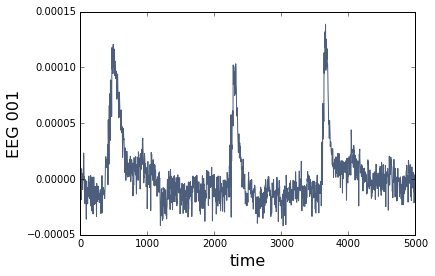

In [5]:
# Now we'll plot a sample timeseries
data.plot('time', ['EEG 001'])

In [6]:
# What do you notice about this signal? Any repeating patterns?

# What are the values of the y-axis?

In [7]:
# Let's look at the time values for this signal.
data['time']

array([   0,    2,    3, ..., 4997, 4998, 5000])

These tell us how much time passes between observations of the signal. It's a crucial piece of information in order to do many analyses in neuroscience.

The **sampling frequency** (or sampling rate) is the number of samples we record *per second*. We can calculate this by taking $\frac{1}{time\_between\_samples}$

In [8]:
# How would we calcaulte the sampling frequency of this signal?
sampling_freq = 1. / (data['time'][1] - data['time'][0])

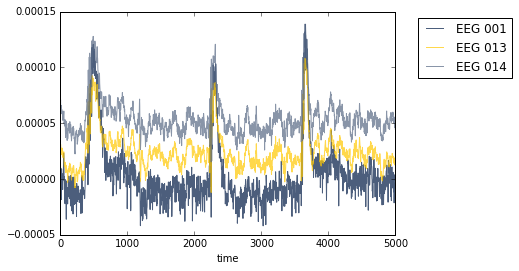

In [9]:
# Let's plot a couple of other channels as well, and see how they compare
data.plot('time', ['EEG 001', 'EEG 013', 'EEG 014'])

In [10]:
# What do you notice about these channels? How are they different? How are they the same?

## Using MNE to represent our data
Because a timeseries has a specific structure (signals varying over time), there are a number of packages designed to handle this particular kind of data. One of the best python packages for neuroscience is called `MNE-python`. Check out their website here: http://martinos.org/mne/stable/index.html

MNE has code that can handle datasets like the one we've used above. They have a number of "classes" that handle different kinds of datasets. Here is a short-list of classes that you can use:

* `Raw` - raw data sets. (n_channels x n_times)
* `Epochs` - datasets that have been split into windows around times of interest (n_trials x n_channels x n_times_in_window)
* `Evoked` - datasets that have been averaged across trials. (n_channels x n_times_in_window)

Today, we'll focus on the `Raw` data, because it makes viewing your data much easier.

In [11]:
# We'll load the same dataset, this time with MNE code
raw = mne.io.Raw('../../data/eeg/mne_sample/mne_sample-raw.fif', preload=True)
raw

<Raw  |  mne_sample-raw.fif, n_channels x n_times : 59 x 166800 (277.7 sec), ~78.2 MB, data loaded>

The benefit of using neuro-specific classes (like those in MNE-python) is that we can make assumptions about the data in order to allow us to do more complicated things very easily.

For example, any object that represents data in `MNE-python` will have an `info` attribute. This is a collection of information about the data at hand. It includes information like:

* `info['sfreq']` - The sampling frequency of the data
* `info['ch_names']` - The names of channels in the data
* `info['bads']` - A list of "bad" channels
* `info['chs']` - A more complex collection of channel information, such as xyz location.

There are many other pieces of information related to things that are important in EEG analysis, most of which we won't go into.

In [12]:
# Here's a list of all the things in an Info object
raw.info

<Info | 25 non-empty fields
    acq_pars : 'str | 13886 items
    bads : 'list | 0 items
    buffer_size_sec : 'numpy.float64 | 10.0014153787
    ch_names : 'list | EEG 001, EEG 002, EEG 003, EEG 004, EEG 005, EEG 006, ...
    chs : 'list | 59 items (EEG: 59)
    comps : 'list | 0 items
    custom_ref_applied : 'bool | False
    description : 'str | 49 items
    dev_head_t : 'mne.transforms.Transform | 3 items
    dig : 'list | 146 items
    events : 'list | 1 items
    experimenter : 'str | 3 items
    file_id : 'dict | 4 items
    filename : 'str | /Users/cho.../mne_sample-raw.fif
    highpass : 'float | 0.10000000149011612 Hz
    hpi_meas : 'list | 1 items
    hpi_results : 'list | 1 items
    lowpass : 'float | 172.17630004882812 Hz
    meas_date : 'numpy.ndarray | 2002-12-03 11:01:10
    meas_id : 'dict | 4 items
    nchan : 'int | 59
    proj_id : 'numpy.ndarray | 1 items
    proj_name : 'str | 4 items
    projs : 'list | PCA-v1: off, PCA-v2: off, PCA-v3: off, ...
    sfreq : 'fl

Using MNE objects also gives us **methods** that can do particularly useful things. For example, we can easily crop the data in order to keep only a subset of times:

In [13]:
# We can easily select subsets of the data for plotting
raw_crop = raw.crop(0, 2)

# However, be careful because this often modifies our data in-place
raw

<Raw  |  mne_sample-raw.fif, n_channels x n_times : 59 x 1202 (2.0 sec), ~3.6 MB, data loaded>

In [14]:
# To get around this, we can run `copy` before modifying the data
# Note this is specific to MNE, it may not work on other packages
raw = mne.io.Raw('../../data/eeg/mne_sample/mne_sample-raw.fif', preload=True)
raw.copy().crop(0, 2)

<Raw  |  mne_sample-raw.fif, n_channels x n_times : 59 x 1202 (2.0 sec), ~3.6 MB, data loaded>

We can also use more complex methods for things like data analysis and plotting, which we'll cover later.

You may have noticed that we used a flag `preload=True` when loading this data. By default (or if `preload=False`), MNE will not actually load in the data when you create the object. This is in order to save memory until it is needed. However, our data won't be so large so we'll always preload it.

In [15]:
# If the data has been preloaded (preload=True), then you can access the
# raw data here:
raw._data

array([[  1.13989260e-05,   9.85015885e-06,   7.68188489e-06, ...,
          2.82495122e-05,   2.28598026e-05,   2.38510136e-05],
       [  4.28260794e-05,   4.34135428e-05,   4.38835135e-05, ...,
          7.59002670e-05,   7.51365646e-05,   7.68989547e-05],
       [  3.62602856e-05,   3.11922923e-05,   3.27609569e-05, ...,
          7.04692406e-05,   6.73319114e-05,   7.01072411e-05],
       ..., 
       [  6.91091911e-05,   7.08782951e-05,   7.06500236e-05, ...,
          9.58740223e-05,   9.59881581e-05,   9.90127552e-05],
       [  3.88542173e-05,   4.07510373e-05,   4.09957883e-05, ...,
          6.72453304e-05,   6.68782039e-05,   6.91421504e-05],
       [  6.58391126e-05,   6.80025648e-05,   6.81779798e-05, ...,
          8.51932390e-05,   8.58948991e-05,   8.89938982e-05]])

## Plotting raw data with MNE
MNE has a lot of plotting functionality, which is one of the most important things to do in data analysis. Below we'll explore the basic ways in which we can visualize our data.

In [16]:
# To use this, we'll need to activate "interactive" mode
# This lets us keep plots interactive in the notebook
%matplotlib notebook

First, we'll plot the raw data. This will give us an output of traces, one for each channel. The x-axis is time (in seconds). What we are looking at is the electrical activity (voltage) recorded at the scalp, and generated by neural activity.

<IPython.core.display.Javascript object>


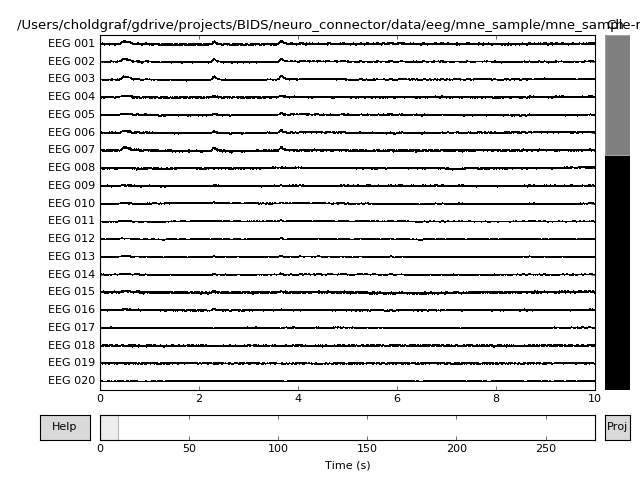

<IPython.core.display.Javascript object>


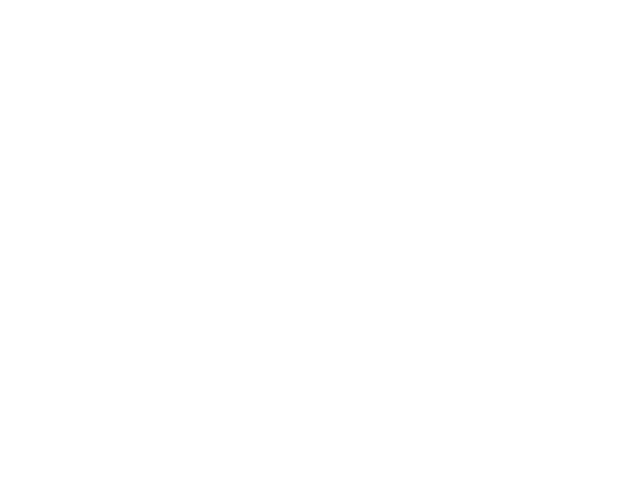

In [17]:
# Putting `_` before the equals sign tells Python to throw away the output
# Otherwise, it will make 2 plots.
_ = raw.plot(scalings='auto')

You can browse this data interactively. Here are a few points:

* Hover over points in the data. A green bar will appear, along with the time (in seconds) for that point.
* Click on a channel, it will turn grey. This is for marking "bad" channels. Bad channel information will be stored in the `Raw` data object.
* Press the arrow keys. Left/Right will move forward and backward in time. up/down will move through channels.
* Press the `-` or `=` key. This will scale the channels up and down in amplitude to make things easier to see.
* If you want to stop the interactivity, press the "power" button to the top right

There is a lot of other functionality in MNE plotting, but we won't go into that here.

In [18]:
# Why are some lines inverted relative to others?
# Why are some lines higher / lower than others?

## Plotting sensor locations
Patterns of recorded neural activity wouldn't be very useful without knowing where that activity was generated. In EEG and ECoG our sensors sit on the scalp and the surface of the brain, respectively.

MNE has simple functions for plotting the location of sensors with EEG. We can see this below:

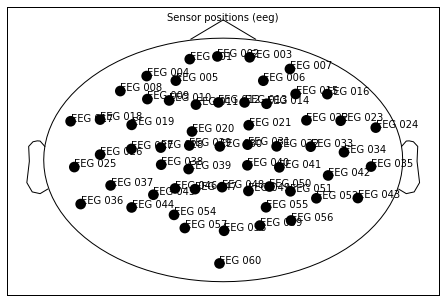

In [23]:
# We can look at the layout of channels on the brain.
# Almost all EEG setups have the same general structure.
_ = raw.plot_sensors(show_names=True)

<IPython.core.display.Javascript object>


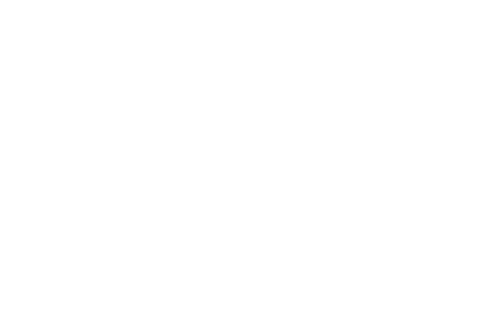

<IPython.core.display.Javascript object>


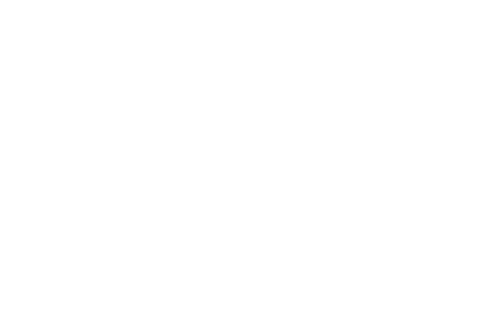

In [21]:
# We can also plot in 3d
_ = raw.plot_sensors('3d')

In ECoG things are a bit more complicated, because each ECoG grid is unique (just as each person's brain is unique). We'll cover plotting data in ECoG later on.